## Model Creation

In [1]:
# Different layers
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, Input, Dense
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, Layer, Dropout
from tensorflow.keras.layers import GlobalAveragePooling1D, Conv1D
from tensorflow.keras.layers import Attention, AdditiveAttention
# For miscellaneous functions
from tensorflow import convert_to_tensor
from tensorflow.keras import utils
# Keras models
from tensorflow.keras import Model, Sequential
# For evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# For math/arrays
import numpy as np
# For plotting
import matplotlib.pyplot as plt
# For importing and processing HybrIK files
import os
import pickle
import scipy.optimize
from tensorflow.keras.optimizers import Adam

### Preparing Data

In [2]:
def extract_gait_cycle(feet_distances):
    '''
    To extract gait cycle according to the pattern of graph
    Output: a list of estimated start and end index for gait cycles
    '''
    y = feet_distances
    close_feet_count = 0
    cycle_start = 0

    if y[1] < y[0] :
        open_feet = False
        cycle_start = -1
    else:
        open_feet = True

    cycle_list = list()

    for i in range(1, len(feet_distances)):
        if y[i] < y[i-1] and open_feet:
            open_feet = False
        elif y[i] > y[i-1] and not open_feet:
            open_feet = True
            if cycle_start == -1:
                cycle_start = i
                continue

            close_feet_count = close_feet_count + 1
            if close_feet_count % 2 == 0:
                cycle_end = i - 1
                cycle_list.append((cycle_start, cycle_end))

                cycle_start = cycle_end

    return cycle_list

In [3]:
def fit_sin(tt, yy):
    '''
    Use coordinates given to produce sine graph
    '''
    tt = np.array(tt)
    yy = np.array(yy)

    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

In [4]:
def process_single_file (data, coord_pos) :
    '''
    data: all data from one single pickle file
    coord_pos: 0 for x coordinates, 1 for y coordinates, 2 for z coordinates
    '''
    LEFT_ANKLE = 7
    RIGHT_ANKLE = 8
    feet_distances = []
    gait_cycles = []

    # Get distance between left and right ankles as feet distance
    for i, frame in enumerate(data['pred_uvd']):
        LAnkle = frame[LEFT_ANKLE, coord_pos]
        RAnkle = frame[RIGHT_ANKLE, coord_pos]

        feet_distance = abs(LAnkle - RAnkle)
        feet_distances.append(feet_distance)

    # Fit the feet distances data into sine graph,
    # to remove outliers or inconsistent patterns
    x = np.array(range(0, len(feet_distances)))
    try:
        f = fit_sin(x, feet_distances)["fitfunc"]
        y = f(x)
        gait_cycles = extract_gait_cycle(y)
        #print(gait_cycles)
    except:
        # Fit the feet distances data into polynomial graph,
        # when it cannot fit into sine graph or no gait cycles found from sine graph
        if len(gait_cycles) <= 0:
            from scipy.interpolate import splrep, splev
            max_distance = max(feet_distances)
            smoothness = max_distance ** 2
            bspl = splrep(x,feet_distances,s=smoothness)
            y = splev(x,bspl)
            gait_cycles = extract_gait_cycle(y)
            #print(gait_cycles)

    return gait_cycles

In [5]:
def extract_gait_information(file, data):
    '''
    Get gait start and end index lists according to the gait's view
    '''
    if 'front' in file.lower() or 'back' in file.lower():
        return process_single_file(data, 2)
    elif 'left' in file.lower() or 'right' in file.lower():
        return process_single_file(data, 0)

In [6]:
def extract_data(input_file, max_length):
    '''
    Extract all samples and labels from the input file.
    Return any file not met maximum sequence length as error files
    '''
    all_samples = []
    all_labels = []
    error_files = []

    for file in os.listdir(input_file):

        # Process only HybrIK pickle files
        if not file.endswith('.pk'):
            continue

        # Extract features with shape (sample_size, frame_num, keypoints_num * xyz)
        file_path = os.path.join(input_file, file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        full_keypoints = data['pred_xyz_24_struct']
        #full_keypoints = data['pred_xyz_29']
        total_frames = len(full_keypoints)

        gait_cycles = extract_gait_information(file, data)
        mid_index = len(gait_cycles) // 2

        # Take middle gait cycles if possible
        start_index = gait_cycles[mid_index][0] if len(gait_cycles) > 0 else 0
        final_index = start_index + max_length - 1

        # If max sequence length is greater than total frames of files,
        # the file will not be used for processing
        if final_index >= total_frames:
            if max_length <= total_frames:
                start_index = 0
                final_index = max_length - 1
            else:
                error_files.append((file, total_frames))
                continue

        keypoints = []

        for i in range(start_index, final_index + 1) :
            keypoints.append(list(full_keypoints[i].flat))

        # Extract label
        # Check for gender
        if 'F' in file:
            gender = 1
        else:
            gender = 0

        # Check for age group
        from drive.MyDrive.model_preprocessing import process
        age = process(file)
        #age = int(file.split("_")[3])
        if age <= 0:
            continue
        elif age < 15:
            group = 0 # Child group
        elif age < 65:
            group = 1 # Adult group
        else:
            group = 2 # Senior group

        # Male child = 0
        # Female child = 1
        # Male adult = 2
        # Female adult = 3
        # Male senior = 4
        # Female senior = 5
        label = 2 * group + gender

        all_samples.append(keypoints)
        all_labels.append(label)

    return all_samples, all_labels, error_files

In [7]:
# Locate dataset for train, validation and test set
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
input_folder = "/content/drive/MyDrive"
test_folder = os.path.join(input_folder, "PK_test_set")

# Set sequence length
sequence_length = 60

# Retrieve dataset
all_error_files = []
X_test, y_test, error_files = extract_data(test_folder, sequence_length)
all_error_files.extend(error_files)

# Print processing results
print("Test set:", len(X_test))
if len(all_error_files) > 0:
    print("Error in processing files:")
    for file in all_error_files:
        print(f"\t- {file[0]} ({file[1]} frames)")

Mounted at /content/drive
Test set: 274


In [8]:
# Calculate number of output classes
n_classes = len(np.unique(y_test))

# Calculate dimension of vector that similar to embedding
num_coord = 24
xyz = 3
embed_dim = num_coord * xyz

# Convert list to tensor
X_test_tensor = convert_to_tensor(X_test, dtype = np.float32)

# Convert labels using one hot encoding
y_test_categorical = utils.to_categorical(y_test)

# Print processing results
print(len(X_test_tensor), len(y_test))
print(X_test_tensor.shape)
print(n_classes)

274 274
(274, 60, 72)
6


In [9]:
# Check frequency of each class in train dataset
label, counts = np.unique(y_test, return_counts=True)
#label, counts = np.unique(y_train_resampled, return_counts=True)
print(dict(zip(label, counts)))

{np.int64(0): np.int64(23), np.int64(1): np.int64(27), np.int64(2): np.int64(84), np.int64(3): np.int64(100), np.int64(4): np.int64(27), np.int64(5): np.int64(13)}


### Model Components

#### MHFA

In [10]:
class Config:
    def __init__(self):
        self.d_model = 72
        self.n_heads = 2
        self.d_kv_comp = 16
        self.d_rope = 16
        self.dropout = 0.4
        self.seq_len = 60

config = Config()

class RotaryEmbedding(tf.keras.Model):
    def __init__(self, dim, scale=40):
        super().__init__()
        assert dim % 2 == 0, "Dimension must be even for rotary embeddings"
        self.dim = dim
        self.inv_freq = 1.0 / (10000 ** (tf.range(0, dim // 2, 2, dtype=tf.float32) / (dim // 2)))
        self.scale = scale

    def call(self, seq_len):
        t = tf.range(seq_len, dtype=self.inv_freq.dtype) / self.scale
        freqs = tf.einsum("i,j->ij", t, self.inv_freq)
        return tf.concat([freqs, freqs], axis=-1)

def rotate_half(x):
    x1, x2 = tf.split(x, num_or_size_splits=2, axis=-1)
    return tf.concat([-x2, x1], axis=-1)

def apply_rotary(x, cos, sin):
    """
    Apply rotary embeddings to the first half of x.
    """
    # Split x into two parts: one for rotary embeddings and the other untouched
    x_rot, x_base = tf.split(x, num_or_size_splits=[tf.shape(cos)[-1], tf.shape(x)[-1] - tf.shape(cos)[-1]], axis=-1)
    # Apply rotary embeddings to the rotary part
    x_rot = (x_rot * cos) + (rotate_half(x_rot) * sin)
    # Concatenate the rotary-applied and base parts
    return tf.concat([x_rot, x_base], axis=-1)

class MemoryOptimizedMLA(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d_head = config.d_model // config.n_heads
        self.split_dim = self.d_head - config.d_rope

        # Projections
        self.W_dkv = tf.keras.layers.Dense(config.d_kv_comp, input_shape=(config.d_model,))
        self.W_dq = tf.keras.layers.Dense(config.d_kv_comp, input_shape=(config.d_model,))

        # Changed value projection to use d_head instead of split_dim
        self.W_uk = tf.keras.layers.Dense(config.n_heads * self.split_dim, input_shape=(config.d_kv_comp,))
        self.W_uv = tf.keras.layers.Dense(config.n_heads * self.d_head, input_shape=(config.d_kv_comp,))
        self.W_uq = tf.keras.layers.Dense(config.n_heads * self.split_dim, input_shape=(config.d_kv_comp,))

        self.W_qr = tf.keras.layers.Dense(config.n_heads * config.d_rope, input_shape=(config.d_kv_comp,))
        self.W_kr = tf.keras.layers.Dense(config.n_heads * config.d_rope, input_shape=(config.d_model,))

        self.rotary = RotaryEmbedding(config.d_rope)
        self.output_proj = tf.keras.layers.Dense(config.d_model, input_shape=(config.n_heads * self.d_head,))

        self.dropout = Dropout(config.dropout)

    def call(self, h, past_kv=None):
        batch_size, seq_len, _ = tf.shape(h)[0], tf.shape(h)[1], tf.shape(h)[-1]

        # KV Compression
        c_kv = self.W_dkv(h)
        k = tf.reshape(self.W_uk(c_kv), (batch_size, seq_len, config.n_heads, self.split_dim))
        v = tf.reshape(self.W_uv(c_kv), (batch_size, seq_len, config.n_heads, self.d_head))

        # Query Compression
        c_q = self.W_dq(h)
        q_base = tf.reshape(self.W_uq(c_q), (batch_size, seq_len, config.n_heads, self.split_dim))
        q_rot = tf.reshape(self.W_qr(c_q), (batch_size, seq_len, config.n_heads, config.d_rope))

        # Rotary embeddings with proper dimensions
        rotary_emb = self.rotary(seq_len)
        cos = tf.reshape(tf.cos(rotary_emb), (1, seq_len, 1, -1))  # [1, seq, 1, dim]
        sin = tf.reshape(tf.sin(rotary_emb), (1, seq_len, 1, -1))

        # Apply rotary embeddings
        q_rot = apply_rotary(q_rot, cos, sin)
        k_rot = apply_rotary(
            tf.reshape(self.W_kr(h), (batch_size, seq_len, config.n_heads, config.d_rope)),
            cos, sin
        )

        q = tf.concat([q_base, q_rot], axis=-1)
        k = tf.concat([k, k_rot], axis=-1)

        # Attention computation
        scores = tf.einsum("bqhd,bkhd->bhqk", q, k) / tf.sqrt(tf.cast(self.d_head, dtype=tf.float32))
        attn = tf.nn.softmax(scores, axis=-1)

        if config.dropout != 0:
            attn = self.dropout(attn)

        out = tf.einsum("bhqk,bkhd->bqhd", attn, v)
        out = self.output_proj(tf.reshape(out, (batch_size, seq_len, config.d_model)))

        if config.dropout != 0:
            out = self.dropout(out)

        return out

In [11]:
class EncoderLayer(Layer):
    def __init__(self, total_heads, total_dense_units, embed_dim):
        super(EncoderLayer, self).__init__()
        self.attn1 = Attention(use_scale = True, dropout = 0.4)
        self.multihead = MemoryOptimizedMLA()
        self.nnw = Sequential([Dense(total_dense_units, activation="relu"), Dense(embed_dim)]) # Feed forward network layer
        self.normalize_layer = LayerNormalization() # Normalization

    def call(self, inputs):
        attn_output = self.multihead(inputs)
        normalize_attn = self.normalize_layer(inputs + attn_output)
        attn_output = self.attn1([normalize_attn, normalize_attn])
        normalize_attn = self.normalize_layer(normalize_attn + attn_output)
        nnw_output = self.nnw(normalize_attn)
        final_output = self.normalize_layer(normalize_attn + nnw_output)
        return final_output

#### Mamba block

In [12]:
from dataclasses import dataclass
from typing import Union
from tensorflow import keras
import math
from tensorflow.keras import layers
from einops import rearrange, repeat

# Argument for MAMBA block configuration
@dataclass
class ModelArgs:
    model_input_dims: int = 64
    model_states: int = 64
    projection_expand_factor: int = 2
    conv_kernel_size: int = 4
    delta_t_min: float = 0.001
    delta_t_max: float = 0.1
    delta_t_scale: float = 0.1
    delta_t_init_floor: float = 1e-4
    conv_use_bias: bool = True
    dense_use_bias: bool = False
    layer_id: int = -1
    seq_length: int = 128
    use_lm_head: float = False

    def __post_init__(self):
        self.model_internal_dim: int = int(self.projection_expand_factor * self.model_input_dims)

        self.delta_t_rank = math.ceil(self.model_input_dims/16)
        if self.layer_id == -1:
            self.layer_id = np.round(np.random.randint(0, 1000), 4)

In [13]:
def selective_scan(u, delta, A, B, C, D):
    # first step of A_bar = exp(ΔA), i.e., ΔA
    dA = tf.einsum('bld,dn->bldn', delta, A)
    dB_u = tf.einsum('bld,bld,bln->bldn', delta, u, B)

    dA_cumsum = tf.pad(
        dA[:, 1:], [[0, 0], [1, 1], [0, 0], [0, 0]])[:, 1:, :, :]

    dA_cumsum = tf.reverse(dA_cumsum, axis=[1])  # Flip along axis 1

    # Cumulative sum along all the input tokens, parallel prefix sum,
    # calculates dA for all the input tokens parallely
    dA_cumsum = tf.math.cumsum(dA_cumsum, axis=1)

    # second step of A_bar = exp(ΔA), i.e., exp(ΔA)
    dA_cumsum = tf.exp(dA_cumsum)
    dA_cumsum = tf.reverse(dA_cumsum, axis=[1])  # Flip back along axis 1

    x = dB_u * dA_cumsum
    # 1e-12 to avoid division by 0
    x = tf.math.cumsum(x, axis=1)/(dA_cumsum + 1e-12)

    y = tf.einsum('bldn,bln->bld', x, C)

    return y + u * D

In [14]:
class MambaBlock(layers.Layer):
    def __init__(self, modelargs: ModelArgs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.args = modelargs
        args = modelargs
        self.layer_id = modelargs.layer_id

        self.in_projection = layers.Dense(
            args.model_internal_dim * 2,
            input_shape=(args.model_input_dims,), use_bias=False)

        self.conv1d = layers.Conv1D(
            filters=args.model_internal_dim,
            use_bias=args.conv_use_bias,
            kernel_size=args.conv_kernel_size,
            groups=args.model_internal_dim,
            data_format='channels_first',
            padding='causal'
        )

        # this layer takes in current token 'x'
        # and outputs the input-specific Δ, B, C (according to S6)
        self.x_projection = layers.Dense(args.delta_t_rank + args.model_states * 2, use_bias=False)

        # this layer projects Δ from delta_t_rank to the mamba internal
        # dimension
        self.delta_t_projection = layers.Dense(args.model_internal_dim,
                                               input_shape=(args.delta_t_rank,), use_bias=True)

        self.A = repeat(
                tf.range(1, args.model_states+1, dtype=tf.float32),
                'n -> d n', d=args.model_internal_dim)

        self.A_log = tf.Variable(
                tf.math.log(self.A),
                trainable=True, dtype=tf.float32,
                name=f"SSM_A_log_{args.layer_id}")

        self.D = tf.Variable(
                np.ones(args.model_internal_dim),
                trainable=True, dtype=tf.float32,
                name=f"SSM_D_{args.layer_id}")

        self.out_projection = layers.Dense(
                args.model_input_dims,
                input_shape=(args.model_internal_dim,),
                use_bias=args.dense_use_bias)

    def call(self, x):
        """Mamba block forward. This looks the same as Figure 3 in Section 3.4 in the Mamba pape.
        Official Implementation:
            class Mamba, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L119
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311
        """

        (batch_size, seq_len, dimension) = x.shape

        x_and_res = self.in_projection(x) # shape = (batch, seq_len, 2 * model_internal_dimension)
        (x, res) = tf.split(x_and_res,
                            [self.args.model_internal_dim,
                             self.args.model_internal_dim], axis=-1)

        x = rearrange(x, 'b l d_in -> b d_in l')
        x = self.conv1d(x)[:, :, :seq_len]
        x = rearrange(x, 'b d_in l -> b l d_in')

        x = tf.nn.swish(x)
        y = self.ssm(x)
        y = y * tf.nn.swish(res)
        return self.out_projection(y)

    def ssm(self, x):
        """Runs the SSM. See:
            - Algorithm 2 in Section 3.2 in the Mamba paper
            - run_SSM(A, B, C, u) in The Annotated S4
            Official Implementation:
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311
        """
        (d_in, n) = self.A_log.shape

        # Compute ∆ A B C D, the state space parameters.
        #     A, D are input independent (see Mamba paper [1] Section 3.5.2 "Interpretation of A" for why A isn't selective)
        #     ∆, B, C are input-dependent (this is a key difference between Mamba and the linear time invariant S4,
        #                                  and is why Mamba is called **selective** state spaces)

        A = -tf.exp(tf.cast(self.A_log, tf.float32)) # shape -> (d_in, n)
        D = tf.cast(self.D, tf.float32)

        x_dbl = self.x_projection(x) # shape -> (batch, seq_len, delta_t_rank + 2*n)

        (delta, B, C) = tf.split(
                x_dbl,
                num_or_size_splits=[self.args.delta_t_rank, n, n],
                axis=-1) # delta.shape -> (batch, seq_len) & B, C shape -> (batch, seq_len, n)

        delta = tf.nn.softplus(self.delta_t_projection(delta)) # shape -> (batch, seq_len, model_input_dim)

        return selective_scan(x, delta, A, B, C, D)

In [15]:
class ResidualBlock(layers.Layer):
    def __init__(self, modelargs: ModelArgs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.args = modelargs
        self.mixer = MambaBlock(modelargs)
        self.norm = BatchNormalization(epsilon=1e-5)

    def call(self, x):
        """
        Official Implementation:
            Block.forward(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L297

            Note: the official repo chains residual blocks that look like
                [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> ...
            where the first Add is a no-op. This is purely for performance reasons as this
            allows them to fuse the Add->Norm.

            We instead implement our blocks as the more familiar, simpler, and numerically equivalent
                [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> ....

        """
        return self.mixer(self.norm(x)) + x

### Model Compilation and Load

In [16]:
# Initiation for Transformer block
num_heads = 2
total_dense_units = 256

# Initiation for Mamba block
args = ModelArgs(
    model_input_dims=embed_dim,
    seq_length=sequence_length,
)

# Start connecting the layers together
input_layer = Input(shape=(sequence_length, embed_dim))
mamba_layer_0 = ResidualBlock(args)(input_layer)
mamba_layer_1 = ResidualBlock(args)(mamba_layer_0)
dropout_layer_0 = Dropout(0.2)(mamba_layer_1)
mamba_layer_2 = ResidualBlock(args)(dropout_layer_0)
norm_layer_0 = BatchNormalization(epsilon = 1e-5)(mamba_layer_2)
attn_layer_0 = EncoderLayer(num_heads, total_dense_units, embed_dim)(norm_layer_0)
pool = GlobalAveragePooling1D()(attn_layer_0)
d = Dense(total_dense_units, activation="relu")(pool)
dropout_layer_1 = Dropout(0.6)(d)
output_layer = Dense(n_classes, activation="softmax")(dropout_layer_1)

# Construct the model
saved_model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate = 0.001)
saved_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy', 'Precision', 'Recall'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Load pretrained weights
weights_file = "MAXGait.weights.h5"
saved_model.load_weights(os.path.join(input_folder, weights_file))
scores = saved_model.evaluate(X_test_tensor, y_test_categorical, verbose = 0)
print("Loss:", scores[0])
print("Accuracy: %.2f%%" % (scores[1] * 100))
print("Precision: %.2f%%" % (scores[2] * 100))
print("Recall: %.2f%%" % (scores[3] * 100))

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loss: 2.153409957885742
Accuracy: 72.99%
Precision: 73.70%
Recall: 72.63%


## Cryptography

In [18]:
# For time and memory record
import tracemalloc
import time

class Monitor:
    def __init__(self):
        self.__start_time = None
        self.__start_memory = None
        self.__start_peak_memory = None

    def start(self):
        self.__start_time = time.time()
        tracemalloc.start()
        self.__start_memory, self.__start_peak_memory = tracemalloc.get_traced_memory()

    def end(self, return_result = False):
        end_memory, end_peak_memory = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        time_used = time.time() - self.__start_time
        memory_used = end_memory - self.__start_memory
        peak_memory_used = end_peak_memory - self.__start_peak_memory

        self.__start_time = None
        self.__start_memory = None
        self.__start_peak_memory = None

        if return_result:
            return {
                "time": time_used,
                "memory": memory_used,
                "peak_memory": peak_memory_used
            }
        else:
            print(f"Time used: {time_used:.4f} s")
            print(f"Memory usage: {memory_used / 1024:.4f} kb")
            print(f"Peak memory usage: {peak_memory_used / 1024:.4f} kb" )

In [19]:
# Colab no nummaster and tinyec
!pip install nummaster
!pip install tinyec

  Preparing metadata (setup.py) ... done
  Created wheel for nummaster: filename=nummaster-0.1.1-py3-none-any.whl size=5409 sha256=092d42d33787dd2e75e7b0f65e04f1ffdfbe791a06c8c900443d41bfc2872878
  Stored in directory: /root/.cache/pip/wheels/8c/bc/e8/90e543e41f26ff8c8658d3250013076e10cbf199ef1fdf7769
Successfully built nummaster
  Preparing metadata (setup.py) ... done
  Created wheel for tinyec: filename=tinyec-0.4.0-py3-none-any.whl size=20878 sha256=41d5e3a98aa6804554ea5ecfb6f9646bc0bdd74c95368a2a8c34475c63d52eb2
  Stored in directory: /root/.cache/pip/wheels/db/86/a7/922d884ea8657b29b0231d6566159462328473186637fcc02e
Successfully built tinyec


In [20]:
# Simulate two peers
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms
from cryptography.hazmat.backends import default_backend
from nummaster.basic import sqrtmod
from tinyec import registry
from tinyec import ec
import secrets
import hashlib
import math

class Peer:
    def __init__(self, monitor = False):
        self.__monitor = Monitor()
        self.__curve = registry.get_curve('brainpoolP256r1')

        if monitor:
            self.__monitor.start()

        self.__private_key = secrets.randbelow(self.__curve.field.n)
        self.__public_key = self.__private_key * self.__curve.g

        if monitor:
            result = self.__monitor.end()

        self.__shared_key = None
        self.__nonce = None

    def get_public_key(self):
        return hex(self.__public_key.x) + (hex(self.__public_key.y % 2)) [2:]

    def __decompress_public_key(self, compressed_point):
        x_hex = compressed_point[2:-1]
        y_sign = int(compressed_point[-1:])
        a = self.__curve.a
        b = self.__curve.b
        p = self.__curve.g.p

        x = int(x_hex, 16)
        y = int(sqrtmod((x**3 + a * x + b), p))

        # If not the same parity, then p - y
        if y_sign == bool(y & 1):
            return ec.Point(self.__curve, x, y)

        return ec.Point(self.__curve, x, p - y)

    def generate_shared_key(self, received_pub_key, monitor = False):
        if monitor:
            self.__monitor.start()

        peer_pub_key = self.__decompress_public_key(received_pub_key)
        ecc_shared_key = peer_pub_key * self.__private_key

        key_hash = hashlib.sha256()
        key_hash.update(ecc_shared_key.x.to_bytes(32, "big"))
        key_hash.update(ecc_shared_key.y.to_bytes(32, "big"))
        self.__shared_key = key_hash.digest()

        if monitor:
            self.__monitor.end()

        print("Shared key generated successfully!")

    def generate_nonce(self):
        self.__nonce = secrets.token_bytes(8)
        return self.__nonce

    def set_nonce(self, received_nonce):
        self.__nonce = received_nonce

    def encrypt_text(self, plaintext, counter, monitor = False):
        if self.__nonce is None:
            print("Nonce is not set!")
            return None

        if self.__shared_key is None:
            print("Shared key not yet established")
            return None

        if monitor:
            self.__monitor.start()

        plaintext_bytes = plaintext.encode(encoding="ascii",errors="xmlcharrefreplace")
        counter_bytes = counter.to_bytes(8, "little")
        cipher = Cipher(algorithms.ChaCha20(self.__shared_key, counter_bytes + self.__nonce), mode=None)
        encryptor = cipher.encryptor()
        ciphertext = encryptor.update(plaintext_bytes)

        if monitor:
            self.__monitor.end()

        return ciphertext

    def decrypt_text(self, ciphertext, counter, monitor = False):
        if monitor:
            self.__monitor.start()

        counter_bytes = counter.to_bytes(8, "little")
        cipher = Cipher(algorithms.ChaCha20(self.__shared_key, counter_bytes + self.__nonce), mode=None)
        decryptor = cipher.decryptor()
        m_prime_bytes = decryptor.update(ciphertext)
        m_prime = m_prime_bytes.decode(encoding="ascii",errors="xmlcharrefreplace")

        if monitor:
            self.__monitor.end()

        return m_prime

class Predictor(Peer):
    def __init__(self, model, labels, monitor):
        super().__init__(monitor)
        self.prediction_model = model
        self.labels = labels

    def predict(self, sample, counter):
        y_pred = self.prediction_model.predict(sample, verbose = 0)
        y_pred_label = np.argmax(y_pred)
        result = self.labels[y_pred_label]
        encrypted_result = super().encrypt_text(result, counter)

        return encrypted_result

### Communication Establishment (Key Exchange)

In [21]:
labels = ["Male Child", "Female Child", "Male Adult", "Female Adult", "Male Senior", "Female Senior"]

print("Create Instance\n---------------------")
predictor = Predictor(model = saved_model, labels = labels, monitor = True)
client = Peer()

# Exchange public key (can be viewed publicly)
print("\nExchange keys\n-----------------------")
client.generate_shared_key(predictor.get_public_key())
predictor.generate_shared_key(client.get_public_key(), monitor = True)

# Send nonce for communication session (can be viewed publicly)
client.set_nonce(predictor.generate_nonce())

Create Instance
---------------------
Time used: 0.8362 s
Memory usage: 21.7910 kb
Peak memory usage: 66.5869 kb

Exchange keys
-----------------------
Shared key generated successfully!
Time used: 1.2809 s
Memory usage: 18.6162 kb
Peak memory usage: 53.6699 kb
Shared key generated successfully!


### Communication Data Exchange

#### Encrypt and decrypt single result

In [22]:
sample_text = "Male Child"

monitor = Monitor()

print("Encrypt\n----------------------")
monitor.start()
message_sent = predictor.encrypt_text(sample_text, 0)
results = monitor.end(return_result = True)

print(f"Time used: {results['time']} s")
print(f"Memory usage: {(results['memory'] - message_sent.__sizeof__()) / 1024:.4f} kb")
print(f"Memory usage: {(results['peak_memory'] - message_sent.__sizeof__()) / 1024:.4f} kb")
print("Message sent:", message_sent)

print("\nDecrypt\n-----------------------")
monitor.start()
message_displayed = client.decrypt_text(message_sent, 0)
results = monitor.end(return_result = True)

print(f"Time used: {results['time']} s")
print(f"Memory usage: {(results['memory'] - message_displayed.__sizeof__()) / 1024:.4f} kb")
print(f"Memory usage: {(results['peak_memory'] - message_displayed.__sizeof__()) / 1024:.4f} kb")
print("Message decrypted:", message_displayed)

Encrypt
----------------------
Time used: 0.010935306549072266 s
Memory usage: 8.8018 kb
Memory usage: 19.5713 kb
Message sent: b'\xaa\x1a\x9e \xb3\xfft"\xc2u'

Decrypt
-----------------------
Time used: 0.0006742477416992188 s
Memory usage: 0.9668 kb
Memory usage: 11.7393 kb
Message decrypted: Male Child


#### Encrypt and decrypt multiple results

In [53]:
labels = ["Male Child", "Female Child", "Male Adult", "Female Adult", "Male Senior", "Female Senior"]

print(f"Predict test set results\n----------------------------")

y_pred = []

monitor.start()
for counter, _ in enumerate(X_test_tensor):
    y_pred.append(saved_model.predict(X_test_tensor[counter : counter+1], verbose=0))
results = monitor.end(return_result = True)

print(f"Time used: {results['time']} s")
print(f"Memory usage: {(results['memory'] - y_pred.__sizeof__()) / 1024:.4f} kb")
print(f"Memory usage: {(results['peak_memory'] - y_pred.__sizeof__()) / 1024:.4f} kb")
print()

y_pred_label = np.argmax(np.array(y_pred).squeeze(), axis = 1)
test_number = len(y_pred_label)
samples = list(map(lambda y: labels[y], y_pred_label))

print(f"Encrypt {test_number} results\n--------------------")
messages_sent = []

monitor.start()
for counter, sample in enumerate(samples):
    messages_sent.append(predictor.encrypt_text(sample, counter))
results = monitor.end(return_result = True)

print(f"Time used: {results['time']:.4f} s")
print(f"Memory usage: {(results['memory'] - messages_sent.__sizeof__()) / 1024:.4f} kb")
print(f"Peak memory usage: {(results['peak_memory'] - messages_sent.__sizeof__()) / 1024:.4f} kb")
print("5 messages sent:", messages_sent[:5])

Predict test set results
----------------------------
Time used: 78.33937525749207 s
Memory usage: 2132.6660 kb
Memory usage: 2616.3877 kb

Encrypt 274 results
--------------------
Time used: 0.0220 s
Memory usage: 15.9521 kb
Peak memory usage: 26.8477 kb
5 messages sent: [b'\xa1\x1e\x9f$\xff\xd9<\n\xcad\xd1\xfa', b'*\xcfv\xc5\x8f\x861eC\xe8', b'\xcb\x93\xdbcj\xde\x02+tGu\xf2', b'\xf6i\x8f\xea>\xad\x8a3\x97\xe8\xda\x18', b'\xb8j\xf5\xa6\x17~\x18\xed\x17&']


In [54]:
print(f"Decrypt {test_number} results\n--------------------")
messages_received = []

monitor.start()
for counter, ciphertext in enumerate(messages_sent):
    messages_received.append(client.decrypt_text(ciphertext, counter))
results = monitor.end(return_result = True)

print(f"Time used: {results['time']:.4f} s")
print(f"Memory usage: {(results['memory'] - messages_received.__sizeof__()) / 1024:.4f} kb")
print(f"Peak memory usage: {(results['peak_memory'] - messages_received.__sizeof__()) / 1024:.4f} kb")
print("5 messages received:", messages_received[:5])

Decrypt 274 results
--------------------
Time used: 0.0173 s
Memory usage: 18.3174 kb
Peak memory usage: 29.2139 kb
5 messages received: ['Female Adult', 'Male Adult', 'Female Child', 'Female Child', 'Male Adult']


#### Real test

In [55]:
print("Predict and encrypt test set results\n--------------------")
messages_sent = []

monitor.start()
for counter, _ in enumerate(X_test_tensor):
    messages_sent.append(predictor.predict(X_test_tensor[counter : counter+1], counter))
results = monitor.end(return_result = True)

print(f"Time used: {results['time']:.4f} s")
print(f"Memory usage: {(results['memory'] - messages_sent.__sizeof__()) / 1024:.4f} kb")
print(f"Peak memory usage: {(results['peak_memory'] - messages_sent.__sizeof__()) / 1024:.4f} kb")
print("5 messages sent:", messages_sent[:5])

Predict and encrypt test set results
--------------------
Time used: 79.8535 s
Memory usage: 2085.6514 kb
Peak memory usage: 2177.8926 kb
5 messages sent: [b'\xa1\x1e\x9f$\xff\xd9<\n\xcad\xd1\xfa', b'*\xcfv\xc5\x8f\x861eC\xe8', b'\xcb\x93\xdbcj\xde\x02+tGu\xf2', b'\xf6i\x8f\xea>\xad\x8a3\x97\xe8\xda\x18', b'\xb8j\xf5\xa6\x17~\x18\xed\x17&']


In [56]:
print("Decrypt received prediction results\n--------------------")
messages_received = []

monitor.start()
for counter, ciphertext in enumerate(messages_sent):
    messages_received.append(client.decrypt_text(ciphertext, counter))
results = monitor.end(return_result = True)

print(f"Time used: {results['time']:.4f} s")
print(f"Memory usage: {(results['memory'] - messages_received.__sizeof__()) / 1024:.4f} kb")
print(f"Peak memory usage: {(results['peak_memory'] - messages_received.__sizeof__()) / 1024:.4f} kb")
print("5 messages received:", messages_received[:5])

Decrypt received prediction results
--------------------
Time used: 0.0219 s
Memory usage: 24.9648 kb
Peak memory usage: 35.8613 kb
5 messages received: ['Female Adult', 'Male Adult', 'Female Child', 'Female Child', 'Male Adult']


### Different Message Size

In [42]:
import string
import random
charset = (string.ascii_letters + string.digits)

message_size = [512 * 1024, 1024*1024, (512+1024)*1024, 2048*1024, (2048+512)*1024]
encrypt_time = []
decrypt_time = []
encrypt_mem = []
decrypt_mem = []


for size in message_size:
    # Create message with given size
    selected_chars = random.choices(charset, k=size)
    message = "".join(selected_chars)

    # Encrypt
    monitor.start()
    ciphertext = predictor.encrypt_text(message, counter = 0)
    result = monitor.end(return_result = True)
    encrypt_time.append(result['time'])
    encrypt_mem.append((result['peak_memory'] - ciphertext.__sizeof__()) / 1024)

    # Decrypt
    monitor.start()
    m_prime = client.decrypt_text(ciphertext, counter = 0)
    result = monitor.end(return_result = True)
    decrypt_time.append(result['time'])
    decrypt_mem.append((result['peak_memory'] - ciphertext.__sizeof__()) / 1024)

In [45]:
data = {
    "Message Size (kB)": list(map(lambda s: s / 1024, message_size)),
    "Encryption Time (ms)": list(map(lambda s: s * 1000, encrypt_time)),
    "Decryption Time (ms)": list(map(lambda s: s * 1000, decrypt_time)),
    "Encryption Memory Usage (kB)": list(map(lambda m: m / 1024, encrypt_mem)),
    "Decryption Memory Usage (kB)": list(map(lambda m: m / 1024, decrypt_mem))
}

import pandas as pd
df = pd.DataFrame(data)

df

,Message Size (kB),Encryption Time (ms),Decryption Time (ms),Encryption Memory Usage (kB),Decryption Memory Usage (kB)
0,512.0,0.858545,0.522614,0.500484,0.500354
1,1024.0,1.433611,0.933170,1.000484,1.000354
2,1536.0,1.881361,1.636982,1.500484,1.500354
3,2048.0,2.431631,1.696825,2.000484,2.000354
4,2560.0,2.848625,2.056599,2.500484,2.500354


In [52]:
# To save the result in XLSX
df.to_excel("/content/drive/MyDrive/MessageSize.xlsx", index=False)

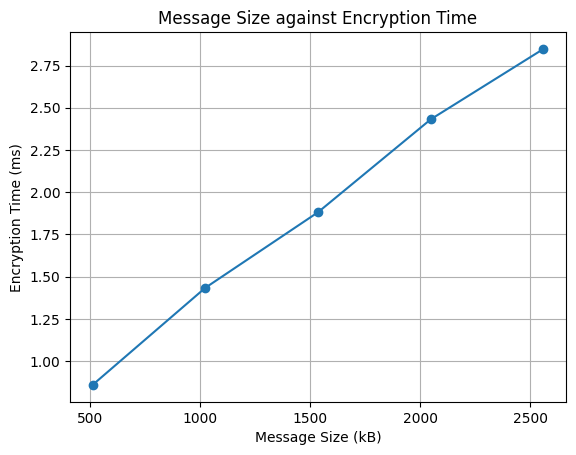

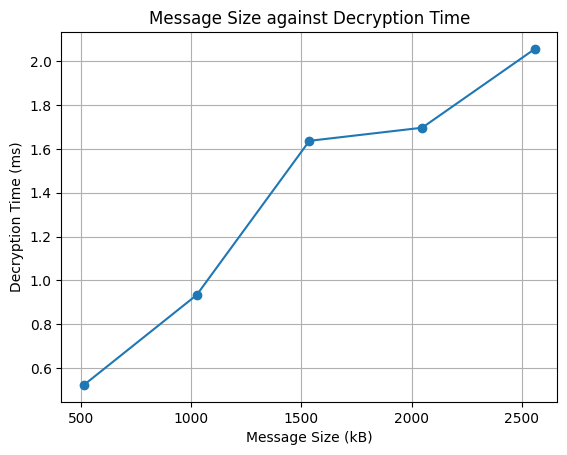

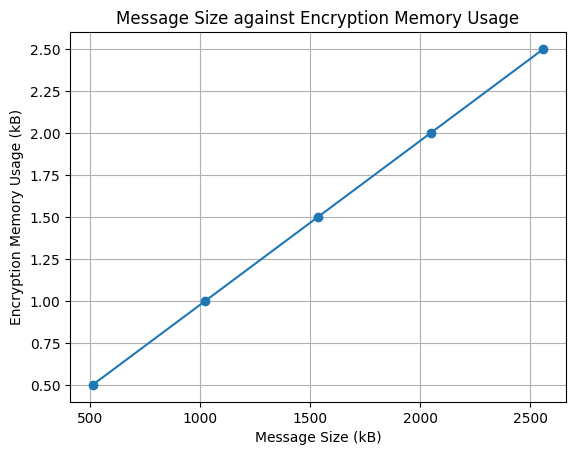

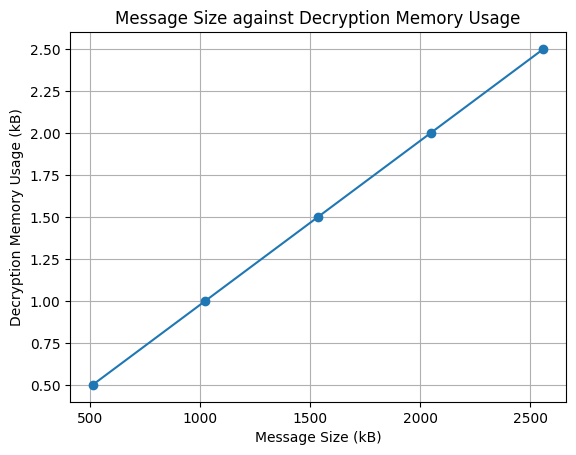

In [51]:
import matplotlib.pyplot as plt

variable = df.columns.tolist()[0]
measurements = df.columns.tolist()[1:]

for measurement in measurements:
    plt.plot(df[variable], df[measurement], marker="o", linestyle='-')
    plt.title(f"{variable[:-5]} against {measurement[:-5]}")
    plt.xlabel(variable)
    plt.ylabel(measurement)
    plt.grid(True)
    plt.show()